In [164]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [165]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [166]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from datetime import datetime


In [167]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [168]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)


In [169]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [170]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [171]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [172]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()




('2017-08-23',)

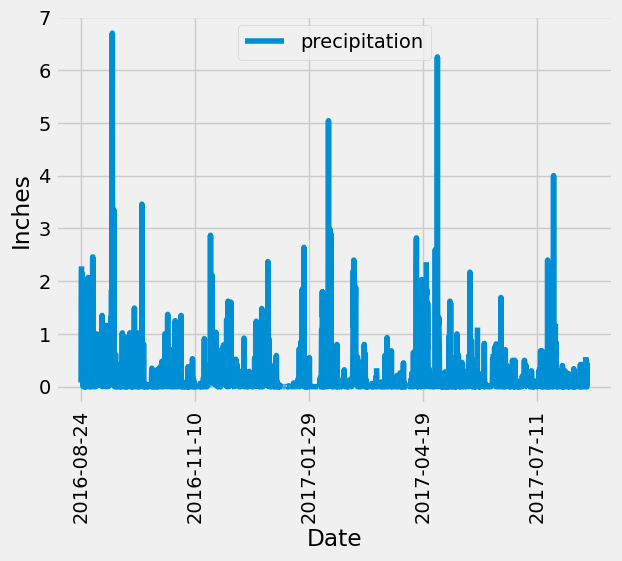

In [284]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_query =session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent = list(map(int,(recent_query.date.replace("-", ", ").split(', '))))

#Grab the integer values for year, month, and day
year = recent[0]
month = recent[1]
day = recent[2]

# Calculate the date one year from the last date in data set.
last_year = dt.date(year, month, day) - dt.timedelta(days=365)
    
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, 
       Measurement.prcp]

last_year_prcp = session.query(*sel).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(last_year_prcp, columns=['Date', 'Precipitation']).set_index("Date")

# Sort the dataframe by date
precip_df.sort_values(by='Date')
precip_df.head()

# ----------------------------------------------------
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot()


#Set Labels and Legend
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=90)
plt.legend(['precipitation'])

plt.show()


In [235]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df[["Precipitation"]].describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [237]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.station)).all()

[(9,)]

In [257]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [281]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active = session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()

most_active_temps = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
                    .filter(Measurement.station == most_active.station).all()

print(most_active_temps)

[(54.0, 85.0, 71.66378066378067)]


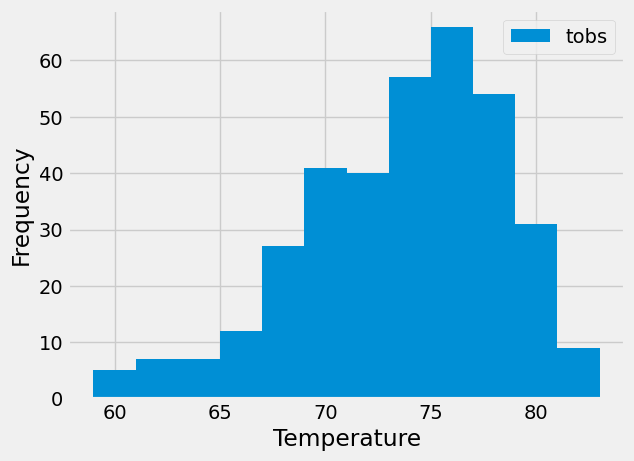

In [329]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#Fetch the last year values
most_active_recent =session.query(Measurement.date) \
        .filter(Measurement.station == most_active.station)\
        .order_by(Measurement.date.desc()).first()


recent = list(map(int,(most_active_recent.date.replace("-", ", ").split(', '))))
year = recent[0]
month = recent[1]
day = recent[2]
# Calculate the date one year from the last date in data set.
last_year = dt.date(year, month, day) - dt.timedelta(days=365)

# Perform a query to retrieve frequency of tobs
last_year_tobs = session.query(Measurement.date, Measurement.tobs)\
    .filter(Measurement.station == most_active.station)\
    .filter(Measurement.date > last_year ).all()

# Create Dataframe
tobs_df = pd.DataFrame(last_year_tobs, columns=['Temperature', 'Frequency']).set_index("Temperature")

# Plot histogram from dataframe
tobs_df.plot.hist(bins=12)

# Create labels and legend for histogram
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.ylim(0,69)
plt.legend(['tobs'])

plt.show()

# Close Session

In [16]:
# Close Session
session.close()